Loading X...
X: 100,000 cells × 2,335 features
Loaded metadata CSV: 100000 rows
Detected 42 subclasses (using k = 42 for KMeans).
Running PCA (200 PCs for clustering)...
PCA done. Shape for clustering: (100000, 200)
Explained variance ratio (first 2 PCs): 0.0298
 GMM ari: 0.3176
 GMM nmi: 0.6793
Running KMeans (k=42, init='k-means++') on 200 PCs...
Saved KMeans labels.
ARI: 0.3021, NMI: 0.6513
Macro-F1: 0.4086, Micro-F1: 0.7956

Classification report:
              precision    recall  f1-score   support

           0     0.9968    0.9905    0.9937       317
           1     0.8816    0.7709    0.8226      1410
           2     0.0000    0.0000    0.0000        23
           3     0.0000    0.0000    0.0000       140
           4     0.0000    0.0000    0.0000        20
           5     0.0000    0.0000    0.0000       492
           6     0.9948    0.8844    0.9363      1929
           7     0.9992    0.9942    0.9967      5013
           8     0.0000    0.0000    0.0000        67
   

/home/ryanghosh/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ryanghosh/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/ryanghosh/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


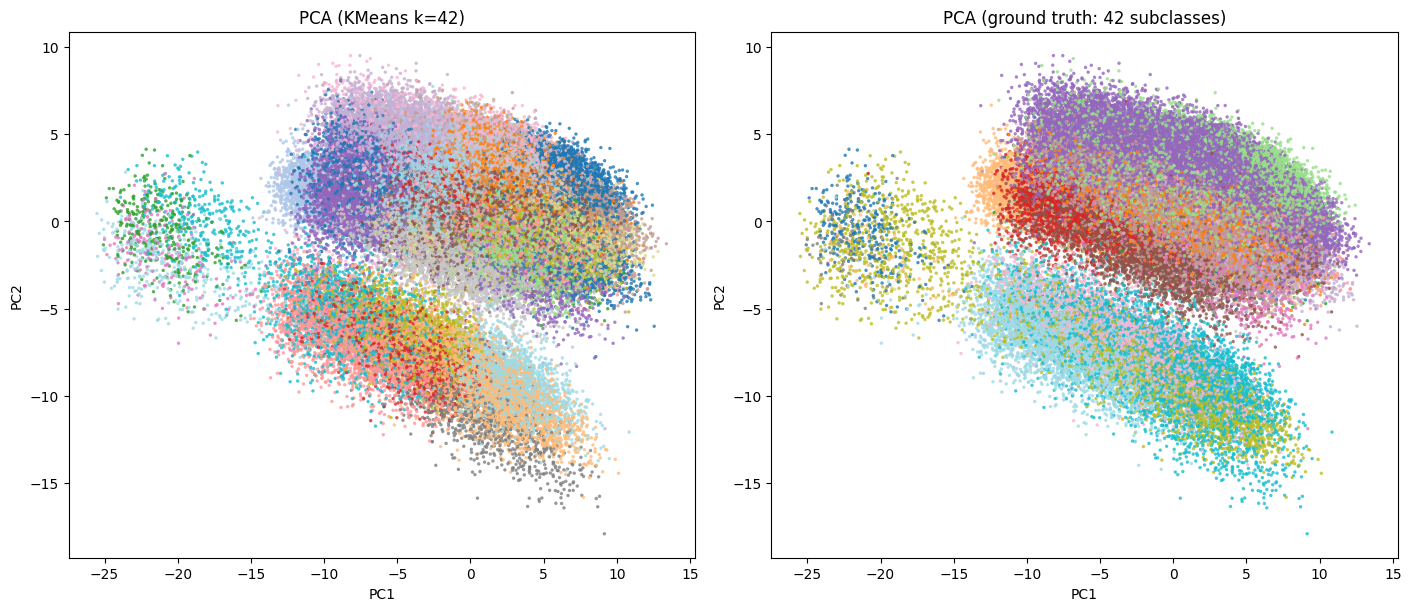

Saved PCA figure.


In [3]:
# PCA -> GMM (run on first N PCs) + visualization (first 2 PCs)
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, classification_report
from sklearn.mixture import GaussianMixture
from sklearn import metrics
# ----------------- CONFIG -----------------
DATA_DIR = Path("desc_data_no_pca")
X_path = os.path.join(DATA_DIR, "X_scaled_hvg.npy")
meta_csv = os.path.join(DATA_DIR, "metadata_subset.csv")
SAMPLE_NAMES_PATH = None  # optional alignment file

OUT_DIR = "pca_gmm_results"
os.makedirs(OUT_DIR, exist_ok=True)

random_state = 42
pca_n_components_for_clustering = 200  # <-- use more PCs for GMM
pca_n_components_for_plot = 2         # <-- for plotting

# ----------------- Load data -----------------
print("Loading X...")
X = np.load(X_path)
n_samples, input_dim = X.shape
print(f"X: {n_samples:,} cells × {input_dim:,} features")

# ----------------- Load metadata -----------------
if not os.path.exists(meta_csv):
    raise FileNotFoundError(f"Metadata CSV not found: {meta_csv}")
meta = pd.read_csv(meta_csv)
print(f"Loaded metadata CSV: {len(meta)} rows")

# Align metadata if SAMPLE_NAMES_PATH provided
if SAMPLE_NAMES_PATH and os.path.exists(SAMPLE_NAMES_PATH):
    if SAMPLE_NAMES_PATH.endswith(".npy"):
        sample_names = list(np.load(SAMPLE_NAMES_PATH))
    else:
        with open(SAMPLE_NAMES_PATH) as f:
            sample_names = [line.strip() for line in f if line.strip()]
    if len(sample_names) != n_samples:
        raise ValueError(f"SAMPLE_NAMES length ({len(sample_names)}) != X rows ({n_samples})")
    meta_indexed = meta.set_index('sample_name')
    meta = meta_indexed.loc[sample_names].reset_index()
    print("Metadata aligned using SAMPLE_NAMES_PATH.")

# ----------------- Determine k -----------------
if 'subclass_label' in meta.columns:
    le = LabelEncoder()
    true_labels = meta['subclass_label'].astype(str).values
    y_int = le.fit_transform(true_labels)
    k = len(le.classes_)
    print(f"Detected {k} subclasses (using k = {k} for KMeans).")
else:
    true_labels = None
    y_int = None
    k = 10
    print("No 'subclass_label' found; using default k = 10.")

# ----------------- PCA -----------------
print(f"Running PCA ({pca_n_components_for_clustering} PCs for clustering)...")
pca = PCA(n_components=pca_n_components_for_clustering, random_state=random_state)
Z_full = pca.fit_transform(X)
print(f"PCA done. Shape for clustering: {Z_full.shape}")
print(f"Explained variance ratio (first {pca_n_components_for_plot} PCs): {pca.explained_variance_ratio_[:pca_n_components_for_plot].sum():.4f}")

# Save PCA coords for all components
pca_out = os.path.join(OUT_DIR, "pca_coords_full.npy")
np.save(pca_out, Z_full)


gmm = GaussianMixture(
    n_components=k,
    covariance_type="diag",
    max_iter=300,
    init_params="kmeans",
)
pred_labels = gmm.fit_predict(Z_full)

ari = metrics.adjusted_rand_score(true_labels, pred_labels)
nmi = metrics.normalized_mutual_info_score(true_labels, pred_labels)
hom = metrics.homogeneity_score(true_labels, pred_labels)
comp = metrics.completeness_score(true_labels, pred_labels)
print(f" GMM ari: {ari:.4f}")
print(f" GMM nmi: {nmi:.4f}")

# ----------------- KMeans on first N PCs -----------------
print(f"Running KMeans (k={k}, init='k-means++') on {pca_n_components_for_clustering} PCs...")
kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, random_state=random_state)
km_labels = kmeans.fit_predict(Z_full)

labels_out = os.path.join(OUT_DIR, "kmeans_labels_on_pca.npy")
np.save(labels_out, km_labels)
print("Saved KMeans labels.")

# ----------------- Evaluation -----------------
if true_labels is not None:
    ari = adjusted_rand_score(true_labels, km_labels)
    nmi = normalized_mutual_info_score(true_labels, km_labels, average_method='arithmetic')
    print(f"ARI: {ari:.4f}, NMI: {nmi:.4f}")
else:
    print("No ground truth — skipping ARI/NMI.")

# ----------------- Macro/Micro F1 -----------------
if true_labels is not None:
    df = pd.DataFrame({"cluster": km_labels, "true": true_labels})
    cluster_to_label = df.groupby("cluster")["true"].agg(lambda x: x.value_counts().index[0]).to_dict()
    predicted_labels = np.array([cluster_to_label[c] for c in km_labels])
    le2 = LabelEncoder()
    y_true_int = le2.fit_transform(true_labels)
    y_pred_int = le2.transform(predicted_labels)
    macro_f1 = f1_score(y_true_int, y_pred_int, average="macro")
    micro_f1 = f1_score(y_true_int, y_pred_int, average="micro")
    print(f"Macro-F1: {macro_f1:.4f}, Micro-F1: {micro_f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true_int, y_pred_int, digits=4))

# ----------------- Plot first 2 PCs -----------------
Z_plot = Z_full[:, :pca_n_components_for_plot]
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True)

ax = axes[0]
ax.scatter(Z_plot[:,0], Z_plot[:,1], c=km_labels, s=6, cmap='tab20', linewidth=0, alpha=0.8)
ax.set_title(f"PCA (KMeans k={k})")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

ax = axes[1]
if true_labels is not None:
    n_true = len(np.unique(y_int))
    ax.scatter(Z_plot[:,0], Z_plot[:,1], c=y_int, s=6, cmap='tab20', linewidth=0, alpha=0.8)
    ax.set_title(f"PCA (ground truth: {n_true} subclasses)")
else:
    ax.text(0.5,0.5,"No ground truth", ha='center', va='center')
    ax.set_title("Ground truth missing")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")

plt_path = os.path.join(OUT_DIR, "pca_kmeans_vs_truth.png")
plt.savefig(plt_path, dpi=150)
plt.show()
print("Saved PCA figure.")
